# RG Argo RAPID-OSNAP into T/S space

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
import numpy as np
import cmocean
import pickle
import gsw
import seawater as sw
import numpy_groupies as npg

from wmt import bin_3D_field_2D
from wmt import calc_tot_trans
from wmt import calc_grid_vol

from matplotlib import cm

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import griddata

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Load RG Argo data
Data extracted and saved within ~/Dropbox/work_general/datasets/RG_Argo/RG_Argo_extract.ipynb

In [38]:
lon_limits = [275, 380]
lat_limits = [25, 45]

fname = '/Users/dgwynevans/Dropbox/work_general/datasets/RG_Argo/RG_temp.nc'
T_dset = xr.open_dataset(fname, decode_times=False)
# T_dset = T_dset.sel(LONGITUDE=slice(lon_limits[0],lon_limits[1]), LATITUDE=slice(lat_limits[0],lat_limits[1]))
T_dset = T_dset.sel(LATITUDE=T_dset.LATITUDE > lat_limits[0])

fname = '/Users/dgwynevans/Dropbox/work_general/datasets/RG_Argo/RG_sal.nc'
S_dset = xr.open_dataset(fname, decode_times=False)
# S_dset = S_dset.sel(LONGITUDE=slice(lon_limits[0],lon_limits[1]), LATITUDE=slice(lat_limits[0],lat_limits[1]))
S_dset = S_dset.sel(LATITUDE=S_dset.LATITUDE > lat_limits[0])

T = T_dset.ARGO_TEMPERATURE_ANOMALY + T_dset.ARGO_TEMPERATURE_MEAN
S = S_dset.ARGO_SALINITY_ANOMALY + S_dset.ARGO_SALINITY_MEAN

time_year = (T_dset.TIME.data / 12) + 2004

In [39]:
mask_dir = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods'
mask = xr.open_dataset(mask_dir)

# mask_nan = mask.basin.data
# mask_nan[mask_nan < 0] = np.nan

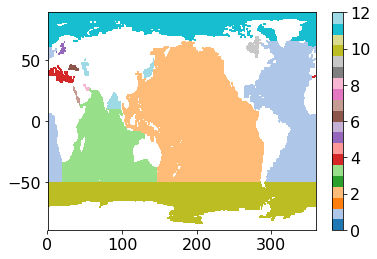

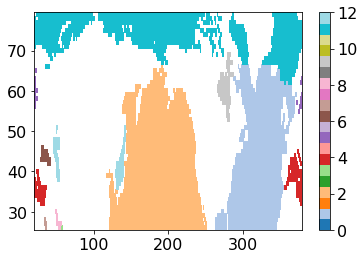

In [40]:
fig, ax = plt.subplots()
CS = ax.pcolormesh(mask.X, mask.Y, mask.basin[0, :, :], vmin=0, vmax=12, cmap=cm.tab20)
cbar = fig.colorbar(CS, ax=ax)

mask_lon_RG = mask.X.data.copy()
mask_lon_RG[mask.X<20] = mask_lon_RG[mask.X<20] + 360
idx = np.argsort(mask_lon_RG)

mask_lon_RG = mask_lon_RG[idx]
mask_srt = mask.basin.data.copy()[:, :, idx]

lon_g, lat_g = np.meshgrid(T_dset.LONGITUDE.data, T_dset.LATITUDE.data)
lon_i = np.repeat(np.expand_dims(lon_g, axis=2), len(T_dset.PRESSURE.data), axis=2).flatten()
lat_i = np.repeat(np.expand_dims(lat_g, axis=2), len(T_dset.PRESSURE.data), axis=2).flatten()
dep_i = np.tile(T_dset.PRESSURE.data, (np.shape(lat_g)[0], np.shape(lat_g)[1], 1)).flatten()

dep_i = -gsw.z_from_p(dep_i, lat_i)

interp_points = np.array([dep_i, lat_i, lon_i]).T
f = rgi((mask.Z.data, mask.Y.data, mask_lon_RG), mask_srt, method='nearest', bounds_error=False)
maski = f(interp_points)
maski = np.reshape(maski, (len( T_dset.LATITUDE.data), len(T_dset.LONGITUDE.data), len(T_dset.PRESSURE.data)))
# maski = np.moveaxis(np.expand_dims(maski, axis=3), [0, 1, 2], [1, 2, 0])
maski = np.moveaxis(maski, [0, 1, 2], [1, 2, 0])

fig, ax = plt.subplots()
CS = ax.pcolormesh(T_dset.LONGITUDE, T_dset.LATITUDE, maski[0, :, :], vmin=0, vmax=12, cmap=cm.tab20)
cbar = fig.colorbar(CS, ax=ax)

Text(0,0.5,'Surface SA [g/kg]')

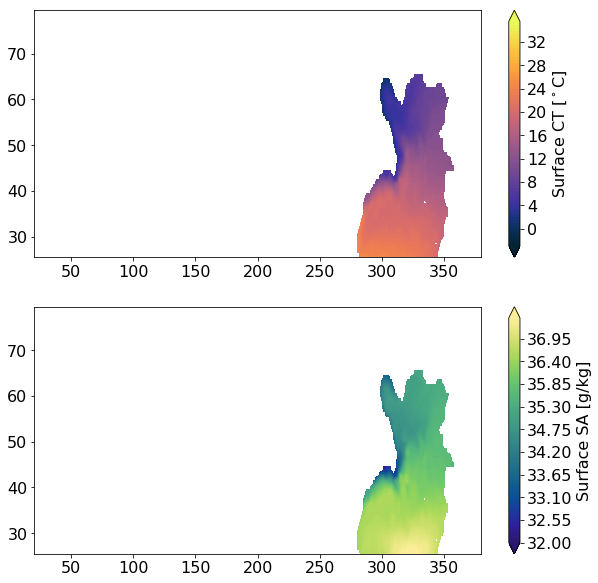

In [47]:
temperature = np.moveaxis(T.data.copy(), 0, -1)
temperature[maski != 1] = np.nan

salinity = np.moveaxis(S.data.copy(), 0, -1)
salinity[maski != 1] = np.nan

fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(2,1)

T_levels = np.arange(-3, 36, 0.5) 
S_levels = np.arange(32, 37.5, 0.05) 

CS_T = ax1.contourf(T_dset.LONGITUDE, T_dset.LATITUDE, temperature[0, :, :, 0],
           T_levels, cmap=cmocean.cm.thermal, extend='both')

CS_S = ax2.contourf(S_dset.LONGITUDE, S_dset.LATITUDE, salinity[0, :, :, 0],
           S_levels, cmap=cmocean.cm.haline, extend='both')

cbarT = fig.colorbar(CS_T, ax=ax1)
cbarT.ax.set_ylabel('Surface CT [$^\circ$C]')

cbarS = fig.colorbar(CS_S, ax=ax2)
cbarS.ax.set_ylabel('Surface SA [g/kg]')

### Now calculate the grid cell volume 

In [48]:
lat = T_dset.LATITUDE.data
lon = T_dset.LONGITUDE.data
pres = T_dset.PRESSURE.data

gr_vol = calc_grid_vol(lon, lat, pres, 'dbar', 0, 2000)

### Loop through each time-step

In [49]:
dS = 0.025
dT = 0.25
S_bin = np.arange(25, 40 + dS, dS)
T_bin = np.arange(-3, 32 + dT, dT)
S_bini = S_bin[0:-1] + dS/2
T_bini = T_bin[0:-1] + dT/2 
S_binii = S_bini[0:-1] + dS/2
T_binii = T_bini[0:-1] + dT/2 

In [63]:
lon_g, lat_g = np.meshgrid(S_dset.LONGITUDE, S_dset.LATITUDE)
lon_g = np.repeat(np.expand_dims(lon_g, axis=0), len(S_dset.PRESSURE), axis=0)
lat_g = np.repeat(np.expand_dims(lat_g, axis=0), len(S_dset.PRESSURE), axis=0)
pres_g = np.moveaxis(np.tile(S_dset.PRESSURE, (np.shape(lon_g)[2], np.shape(lon_g)[1], 1)), [0, 1, 2], [2, 1, 0])
dep_g = -gsw.z_from_p(pres_g, lat_g)

ts_vol = np.zeros((len(T_bini), len(S_bini), np.shape(S)[0]))
ts_lon = np.zeros((len(T_bini), len(S_bini), np.shape(S)[0]))
ts_lat = np.zeros((len(T_bini), len(S_bini), np.shape(S)[0]))
ts_dep = np.zeros((len(T_bini), len(S_bini), np.shape(S)[0]))

bin_edge1 = T_bin
bin_edge2 = S_bin
func = 'sum'

for ii in np.arange(0, np.shape(S)[0], 1):

    SA = gsw.SA_from_SP(salinity[:, :, :, ii], pres_g, lon_g, lat_g)
    CT = gsw.CT_from_t(SA, temperature[:, :, :, ii], pres_g)

    bin1_3D = CT
    bin2_3D = SA
    
    var_3D = gr_vol

    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, func)
    ts_vol[:, :, ii] = out[0]

    var_3D = lon_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lon[:, :, ii] = out[0]

    var_3D = lat_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lat[:, :, ii] = out[0]
    
    var_3D = dep_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_dep[:, :, ii] = out[0]
# ts_vol[ts_vol == 0] = np.nan
    
ts_vol = {'ts_vol': ts_vol, 'ts_lon': ts_lon, 'ts_lat': ts_lat, 'ts_dep': ts_dep, 'S_bini': S_bini, 'T_bini': T_bini, 'S_binii': S_binii, 'T_binii': T_binii, 'time': time_year}
    

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Text(0.5,0,'SA [g/kg]')

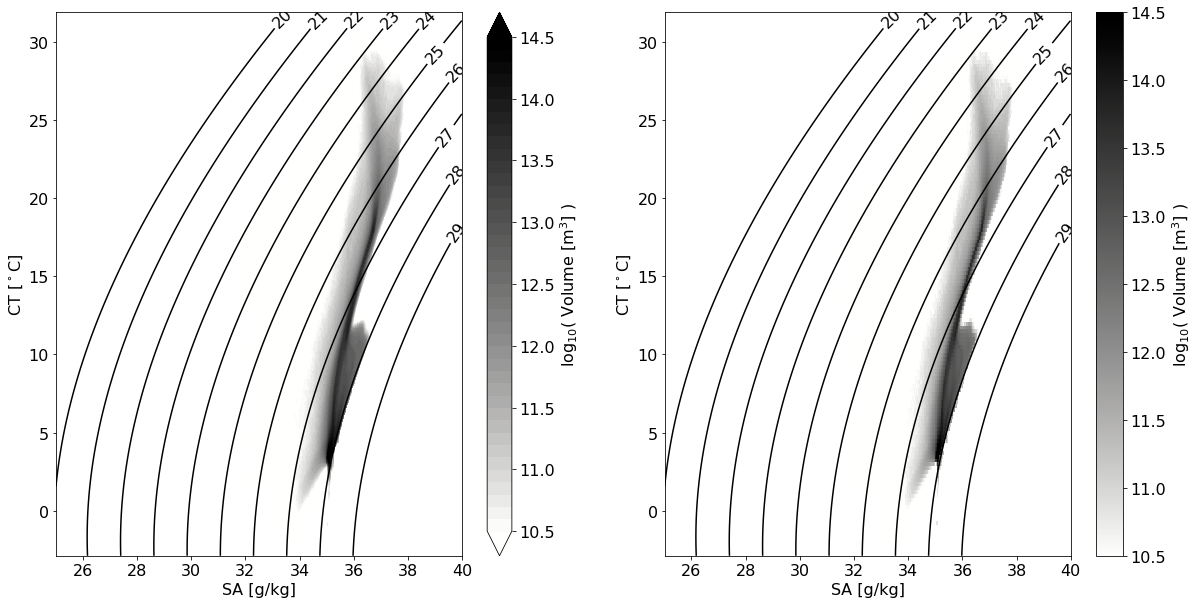

In [64]:
S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

c_lim = (10.5, 14.5)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.contourf(S_bini, T_bini, np.log10(np.nanmean(ts_vol['ts_vol'], axis=2) ), levels, cmap=cmocean.cm.gray_r, extend='both')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol['ts_vol'], axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('log$_{10}$( Volume [m$^3$] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('log$_{10}$( Volume [m$^3$] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

In [65]:
# Difference calculated as n - n-1
# G_t = np.zeros((len(ts_vol['T_bini']) - 1, len(ts_vol['S_bini']), len(ts_vol['time']) ) )
# G_ti = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

# G_s = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']) - 1, len(ts_vol['time']) ) )
# G_si = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

# dvol = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

# tot_trans = {'G_t': G_t.copy(), 'G_s': G_s.copy(), 'G_ti': G_ti.copy(), 'G_si': G_si.copy(), 'dvol': dvol, 'time': ts_vol['time']}

# dt = 30 * 24 * 60 * 60

# dens_limit = (20, 29.5)
# dens_idx = (dens_g < dens_limit[0]) | (dens_g > dens_limit[1])

# ts_vol['ts_vol'][np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0

# for ii in np.arange(0, len(ts_vol['time']), 1):

#     ts_vol_start = ts_vol['ts_vol'][:, :, ii]
#     ts_vol_end = ts_vol['ts_vol'][:, :, ii+1]

#     out = calc_tot_trans(ts_vol_start, ts_vol_end, dt, ts_vol['S_bini'], ts_vol['T_bini'], ts_vol['S_binii'], ts_vol['T_binii'])

#     tot_trans['G_t'][:, :, ii] = out['G_t']
#     tot_trans['G_ti'][:, :, ii] = out['G_ti']
#     tot_trans['G_s'][:, :, ii] = out['G_s']
#     tot_trans['G_si'][:, :, ii] = out['G_si']
#     tot_trans['dvol'][:, :, ii] = out['dvol']

############

# Central difference
G_t = np.zeros((len(ts_vol['T_bini']) - 1, len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )
G_ti = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )

G_s = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']) - 1, len(ts_vol['time']) - 2 ) )
G_si = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )

dvol = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) - 2 ) )

tot_trans = {'G_t': G_t.copy(), 'G_s': G_s.copy(), 'G_ti': G_ti.copy(), 'G_si': G_si.copy(), 'dvol': dvol, 'time': ts_vol['time'][1:-1]}

dt = (30 * 24 * 60 * 60) * 2

dens_limit = (20, 29.5)
dens_idx = (dens_g < dens_limit[0]) | (dens_g > dens_limit[1])

# ts_vol_plus1 = np.dstack((ts_vol['ts_vol'][: , : , 1:], np.zeros(np.shape(ts_vol['ts_vol'])[:-1])))
# ts_vol_minus1 = np.dstack((np.zeros(np.shape(ts_vol['ts_vol'])[:-1]), ts_vol['ts_vol'][: , : , :-1]))

# ts_vol_plus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0
# ts_vol_minus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0

ts_vol_plus1 = ts_vol['ts_vol'][: , : , 2:]
ts_vol_minus1 = ts_vol['ts_vol'][: , : , :-2]

ts_vol_plus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']) - 2, axis=2)] = 0
ts_vol_minus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']) - 2, axis=2)] = 0

for ii in np.arange(0, np.shape(ts_vol_plus1)[2], 1):

    ts_vol_start = ts_vol_minus1[:, :, ii]
    ts_vol_end = ts_vol_plus1[:, :, ii]

    out = calc_tot_trans(ts_vol_start, ts_vol_end, dt, ts_vol['S_bini'], ts_vol['T_bini'], ts_vol['S_binii'], ts_vol['T_binii'])

    tot_trans['G_t'][:, :, ii] = out['G_t']
    tot_trans['G_ti'][:, :, ii] = out['G_ti']
    tot_trans['G_s'][:, :, ii] = out['G_s']
    tot_trans['G_si'][:, :, ii] = out['G_si']
    tot_trans['dvol'][:, :, ii] = out['dvol']


### Save using pickle

To load use the following: </br>

```python
with open(fname, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ts_vol = pickle.load(f)
```

In [75]:
outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/RG_Argo_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump((tot_trans, ts_vol), f, pickle.HIGHEST_PROTOCOL)

In [4]:
dens_limit = 27.5

outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/RG_Argo_TS_dS_{:2.2f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    out = pickle.load(f)

tot_trans = out[0]
ts_vol = out[1]

In [70]:
tot_trans['time'].shape

(186,)

Text(0,0.5,'SA [g/kg]')

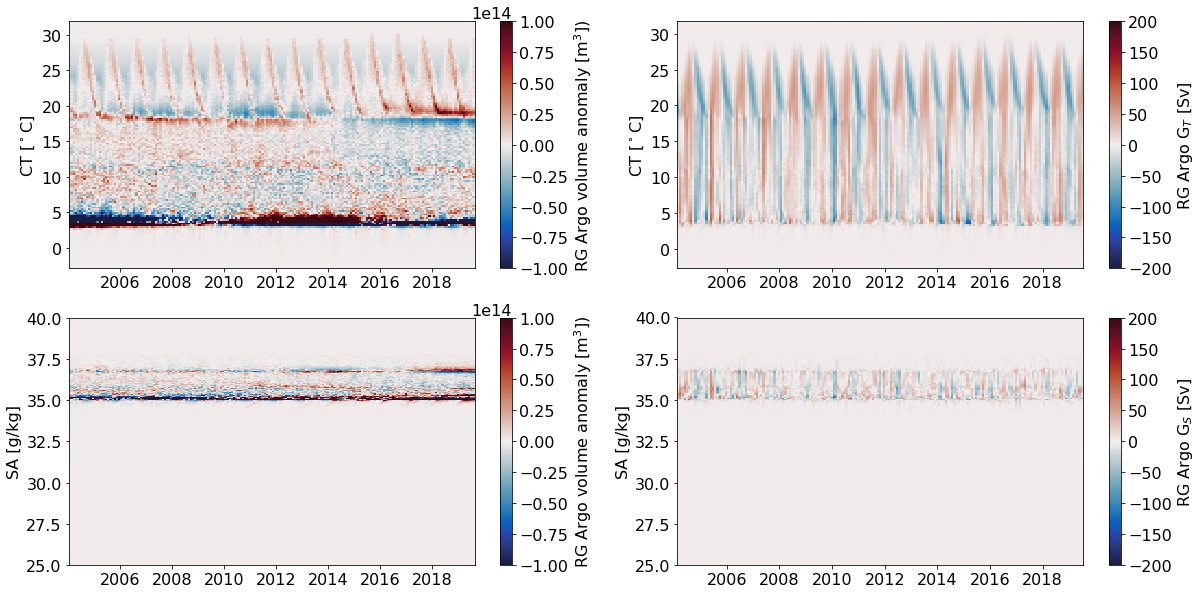

In [71]:
vol_time_anom_t = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=1)
vol_time_anom_s = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=0)

G_t_time_anom_t = np.nansum(tot_trans['G_t'][:, :, 1:-1] - np.expand_dims(np.nanmean(tot_trans['G_t'], axis=2), axis=2), axis=1)
G_s_time_anom_s = np.nansum(tot_trans['G_s'][:, :, 1:-1] - np.expand_dims(np.nanmean(tot_trans['G_s'], axis=2), axis=2), axis=0)

G_t_t = np.nansum(tot_trans['G_t'], axis=1)
G_s_s = np.nansum(tot_trans['G_s'], axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 2)
ax1 = ax[0, 0]
ax2 = ax[1, 0]
ax3 = ax[0, 1]
ax4 = ax[1, 1]

vol_lim = (-1e14, 1e14)
cs_t = ax1.pcolormesh(ts_vol['time'], ts_vol['T_bini'], vol_time_anom_t, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
cs_s = ax2.pcolormesh(ts_vol['time'], ts_vol['S_bini'], vol_time_anom_s, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('RG Argo volume anomaly [m$^3$])')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('RG Argo volume anomaly [m$^3$])')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

trans_lim = (-200, 200)
cs_t = ax3.pcolormesh(ts_vol['time'][1:-1], ts_vol['T_binii'], G_t_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
cs_s = ax4.pcolormesh(ts_vol['time'][1:-1], ts_vol['S_binii'], G_s_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)

cbar = fig.colorbar(cs_t, ax=ax3)
cbar.ax.set_ylabel('RG Argo G$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax4)
cbar.ax.set_ylabel('RG Argo G$_S$ [Sv]')

ax3.set_ylabel('CT [$^\circ$C]')
ax4.set_ylabel('SA [g/kg]')


In [73]:
years = np.floor(ts_vol['time'])
months = np.tile(np.arange(1, 13, 1), len(np.unique(years)))[:len(years)]
days = np.ones(np.shape(years))

datvec = np.vstack((years, months, days)).transpose()
    
G_t = tot_trans['G_t']
G_s = tot_trans['G_s']

G_t_mm = np.zeros((np.shape(tot_trans['G_t'])[0], np.shape(tot_trans['G_t'])[1], 12))
G_s_mm = np.zeros((np.shape(tot_trans['G_s'])[0], np.shape(tot_trans['G_s'])[1], 12))
G_t_mm_an = np.zeros(np.shape(G_t))
G_s_mm_an = np.zeros(np.shape(G_s))

for ii in np.arange(1, 13, 1):
    G_t_mm[:, :, ii - 1] = np.nanmean(G_t[:, :, datvec[1:-1, 1] == ii], axis=2)
    G_s_mm[:, :, ii - 1] = np.nanmean(G_s[:, :, datvec[1:-1, 1] == ii], axis=2)
    
    G_t_mm_an[:, :, datvec[1:-1, 1] == ii] = G_t[:, :, datvec[1:-1, 1] == ii] - np.expand_dims(G_t_mm[:, :, ii - 1], axis=2)    
    G_s_mm_an[:, :, datvec[1:-1, 1] == ii] = G_s[:, :, datvec[1:-1, 1] == ii] - np.expand_dims(G_s_mm[:, :, ii - 1], axis=2)

Text(0,0.5,'SA [g/kg]')

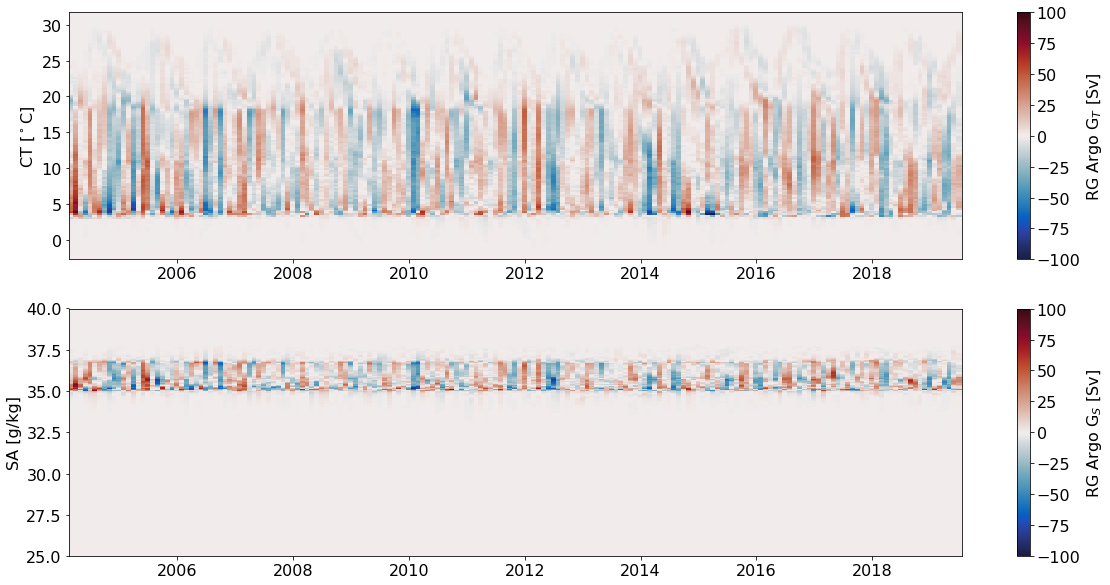

In [74]:
G_t_mm_an_t = np.nansum(G_t_mm_an, axis=1)
G_s_mm_an_s = np.nansum(G_s_mm_an, axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]

trans_lim = (-100, 100)
cs_t = ax1.pcolormesh(ts_vol['time'][1:-1], ts_vol['T_binii'], G_t_mm_an_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
cs_s = ax2.pcolormesh(ts_vol['time'][1:-1], ts_vol['S_binii'], G_s_mm_an_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('RG Argo G$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('RG Argo G$_S$ [Sv]')
ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

### Create a movie of transformations to learn how it's done
https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1 </br>
https://github.com/jbusecke/xmovie

In [12]:
def animate(ii):
    CSdv = ax.pcolormesh(S_bini, T_bini, tot_trans['dvol'][:, :, ii], cmap=cmocean.cm.balance, vmin=c_lim[0], vmax=c_lim[1])

    S_grid, T_grid = np.meshgrid(S_bini, T_bini)
    S_vec = S_grid.flatten(order='F')
    T_vec = T_grid.flatten(order='F')
    G_sv = tot_trans['G_si'][:, :, ii].flatten(order='F')
    G_tv = tot_trans['G_ti'][:, :, ii].flatten(order='F')

    is_flux = (G_sv != 0) | (G_tv != 0)

    q = ax.quiver(S_vec[is_flux], T_vec[is_flux], G_sv[is_flux], G_tv[is_flux], angles='xy', scale=4e8, headlength=8, headwidth=5, headaxislength=6.5, color=(0.3, 0.3, 0.3))
    qk = ax.quiverkey(q, 0.5, 0.9, 1e9,
                 label='1',labelpos='E',
                 coordinates='figure')

    ax.set_title('{:6.2f}'.format(ts_vol['time_year'][ii]))

#     cbar = fig.colorbar(CSdv, ax=ax)
#     cbar.ax.set_ylabel('Volume change [m$^3$]')

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=12, metadata=dict(artist='Me'), bitrate=1800)

c_lim = (-2e7, 2e7)
t_lim = (0, 30)
# s_lim = 
fig, ax = plt.subplots(figsize=(20, 20))[:2]
CS_dens = ax.contour(S_bini, T_bini, dens_g, np.arange(20, 31, 1), colors='k')
ax.clabel(CS_dens, fmt='%2.0f')

ax.set_ylim(t_lim)

ax.set_ylabel('CT [$^\circ$C]')
ax.set_xlabel('SA [g/kg]')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ts_vol['time_year'])-1, repeat=True)

fout = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/TS_trans.mp4'
ani.save(fout, writer=writer)

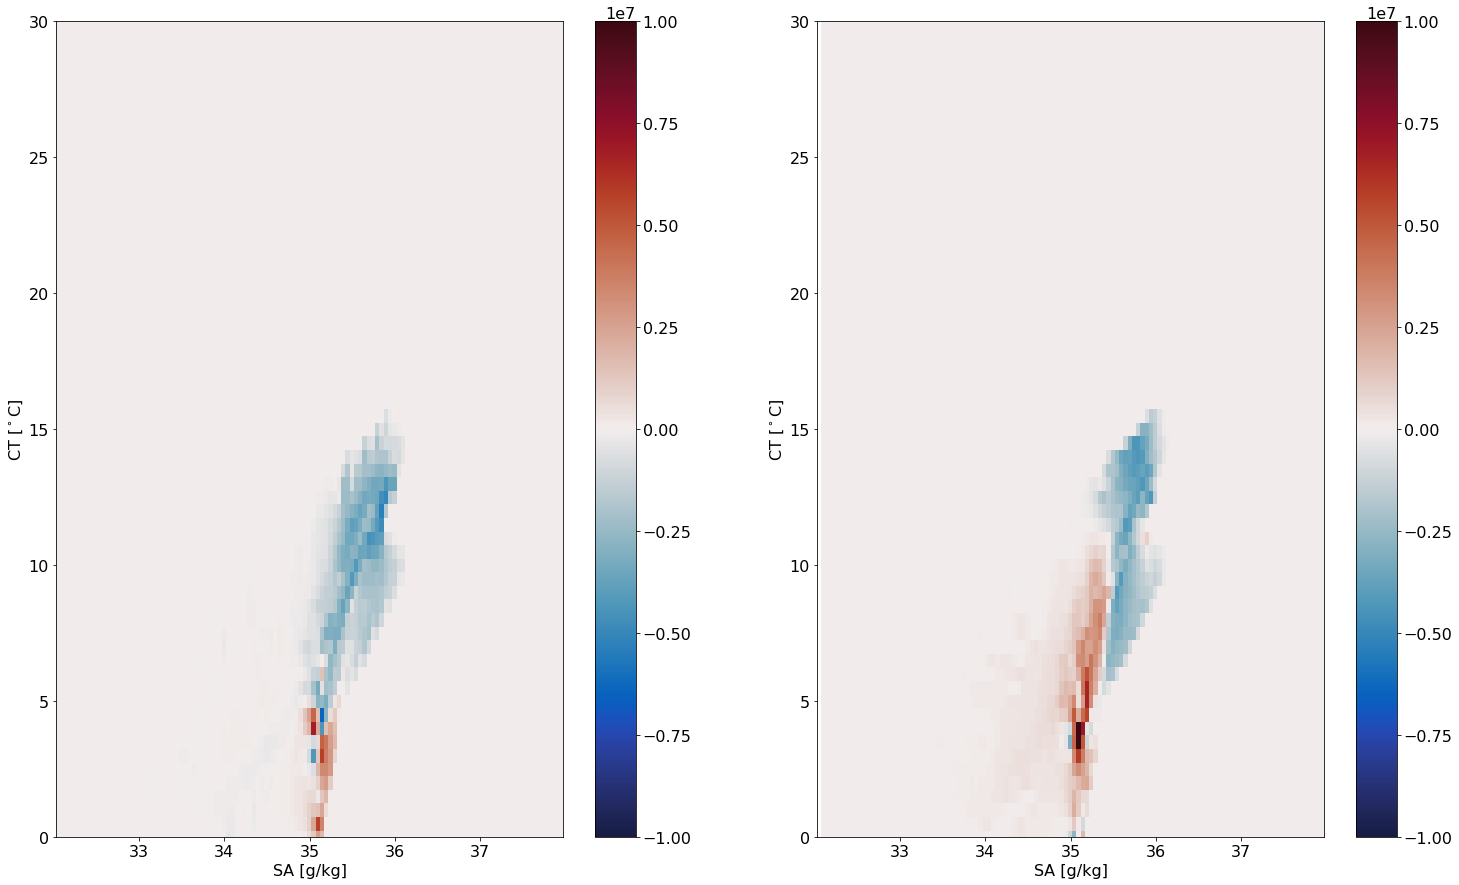

In [30]:
ii = 0
c_lim = (-1e7, 1e7)
t_lim = (0, 30)
# s_lim = 
fig = plt.figure(figsize=(25, 15))
ax1, ax2 = fig.subplots(1, 2)
# CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 31, 1), colors='k')
# ax1.clabel(CS_dens, fmt='%2.0f')

ax1.set_ylim(t_lim)

ax1.set_ylabel('CT [$^\circ$C]')
ax1.set_xlabel('SA [g/kg]')

CSdv = ax1.pcolormesh(S_bini, T_bini, tot_trans['G_ti'][:, :, ii], cmap=cmocean.cm.balance, vmin=c_lim[0], vmax=c_lim[1])

cbar = fig.colorbar(CSdv, ax=ax1)

# CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 31, 1), colors='k')
# ax2.clabel(CS_dens, fmt='%2.0f')

ax2.set_ylim(t_lim)

ax2.set_ylabel('CT [$^\circ$C]')
ax2.set_xlabel('SA [g/kg]')

CSdv = ax2.pcolormesh(S_bini, T_bini, tot_trans['G_si'][:, :, ii], cmap=cmocean.cm.balance, vmin=c_lim[0], vmax=c_lim[1])

cbar = fig.colorbar(CSdv, ax=ax2)
# cbar.ax.set_ylabel('Volume change [m$^3$]')

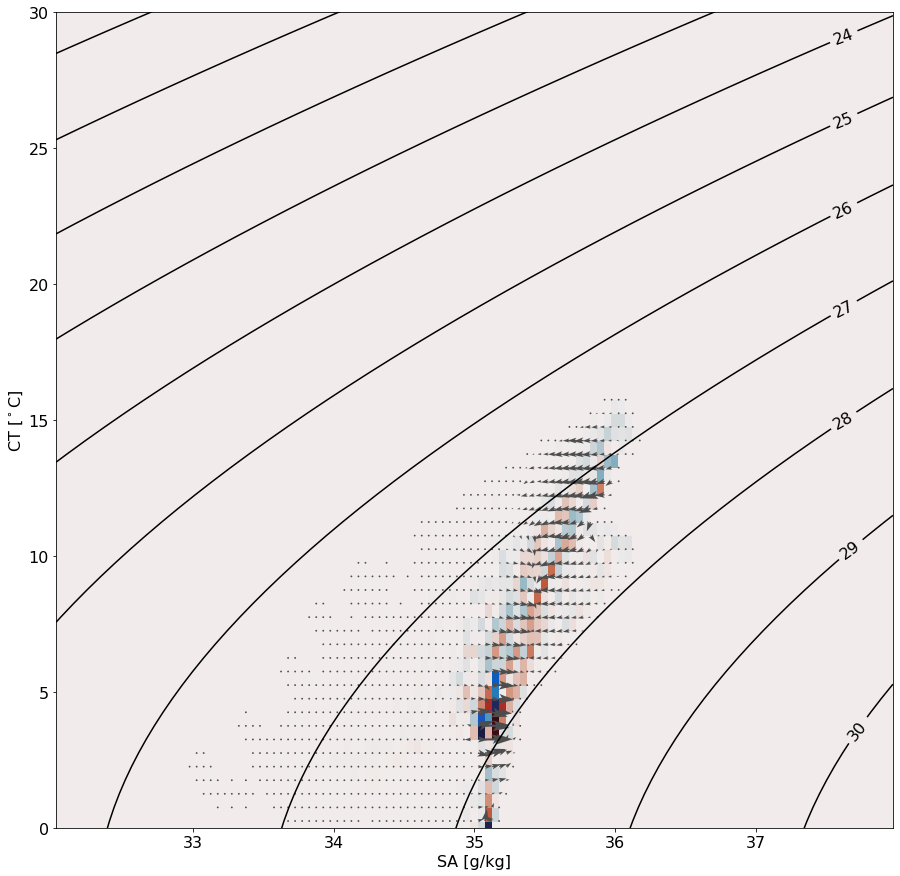

In [31]:
ii = 0
c_lim = (-2e7, 2e7)
t_lim = (0, 30)
# s_lim = 
fig, ax = plt.subplots(figsize=(15, 15))[:2]
CS_dens = ax.contour(S_bini, T_bini, dens_g, np.arange(20, 31, 1), colors='k')
ax.clabel(CS_dens, fmt='%2.0f')

ax.set_ylim(t_lim)

ax.set_ylabel('CT [$^\circ$C]')
ax.set_xlabel('SA [g/kg]')

CSdv = ax.pcolormesh(S_bini, T_bini, tot_trans['dvol'][:, :, ii], cmap=cmocean.cm.balance, vmin=c_lim[0], vmax=c_lim[1])

S_grid, T_grid = np.meshgrid(S_bini, T_bini)
S_vec = S_grid.flatten(order='F')
T_vec = T_grid.flatten(order='F')
G_sv = tot_trans['G_si'][:, :, ii].flatten(order='F')
G_tv = tot_trans['G_ti'][:, :, ii].flatten(order='F')

is_flux = (G_sv != 0) | (G_tv != 0)

q = ax.quiver(S_vec[is_flux], T_vec[is_flux], G_sv[is_flux], G_tv[is_flux], angles='xy', scale=4e8, headlength=8, headwidth=5, headaxislength=6.5, color=(0.3, 0.3, 0.3))
qk = ax.quiverkey(q, 0.5, 0.9, 1e9,
            label='1',labelpos='E',
            coordinates='figure')

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8.114e+03, 9.100e+01, 2.300e+01, 1.600e+01, 8.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([       0.        ,  1096336.14335388,  2192672.28670775,
         3289008.43006163,  4385344.5734155 ,  5481680.71676938,
         6578016.86012325,  7674353.00347713,  8770689.146831  ,
         9867025.29018488, 10963361.43353875]),
 <a list of 10 Patch objects>)

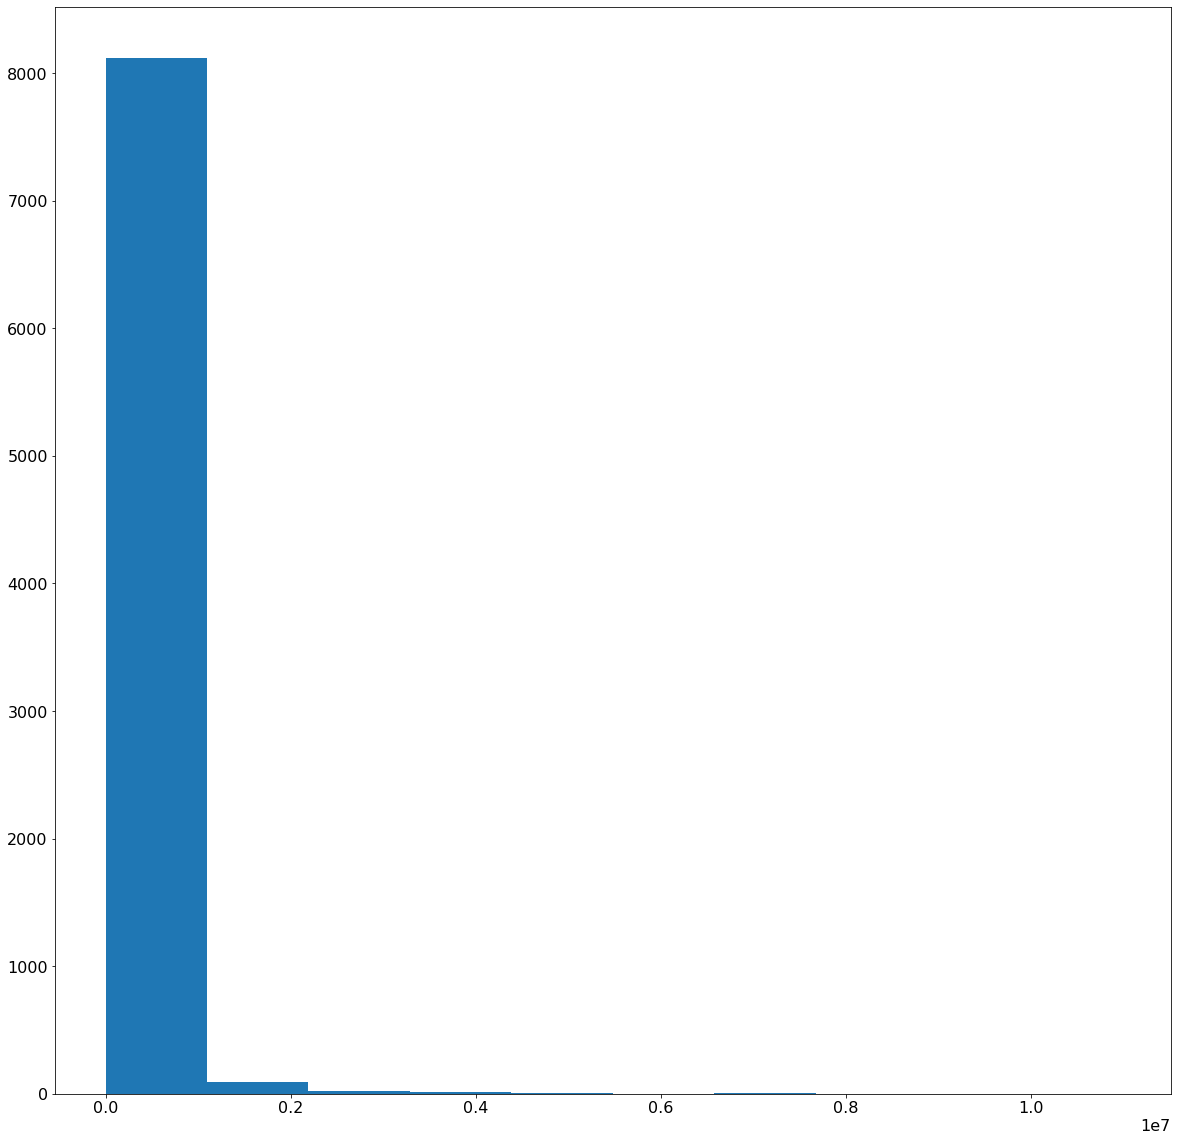

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))[:2]

ax.hist((np.abs(tot_trans['G_si'][:, :, ii].flatten())))
